In [1]:
%load_ext watermark
%watermark

2020-10-11T18:27:10-05:00

CPython 3.7.6
IPython 7.12.0

compiler   : MSC v.1916 64 bit (AMD64)
system     : Windows
release    : 10
machine    : AMD64
processor  : Intel64 Family 6 Model 142 Stepping 10, GenuineIntel
CPU cores  : 8
interpreter: 64bit


In [2]:
import pandas as pd

La magia de matplotlib matplotlib notebook, es muy util para hacer plots mas visibles, pero es un poco complicada de usar ya que requiere el cerrar cada plot para poder continuar.

Alternativamente, se puede usar la magia %matplotlib inline, que es más sencilla ya que simplemente muestra el gráfico original en el jupyter notebook. Para modificar el tamaño de los plots en este caso basta con cambiar el parámetro general de matplotlib figure.figsize al tamaño de gráfico deseado (en pulgadas)

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 

In [4]:
plt.rcParams['figure.figsize'] = (11,11)

En este apartado vamos a revisar el dataset. El objetivo sera tener un dataset lo mas parecido al original pero sin fallos en el mismo que puedan llevarnos a sacar conclusiones erroneas.

El input de este paso es el output del anterior

In [5]:
vehiculos = pd.read_csv('../../_data/vehiculos.1.procesado_inicial.csv')

In [6]:
vehiculos.shape

(38436, 11)

### Duplicados

En este apartado se intentan ver dos cosas:

* Asegurarse de que datos que no debieran estar duplicados no lo están (por ejemplo, numeros de telefono)

* Revisar  si hay columnas que tengan un alto numero de duplicados, ya que pueden no aportar mucha informacion

Recordemos que las entidades posibles eran:   
    
    fabricante
    fabricante-modelo
    fabricante-modelo-año
    fabricante-año

De estas entidades, las unicas que no se deberian repetir coches especificos, es decir, fabricante+modelo +año

In [7]:
vehiculos['modelo_unico'] = vehiculos.fabricante.str.cat([vehiculos.modelo, vehiculos.year.apply(str)],sep='-')

In [8]:
vehiculos.modelo_unico.value_counts()

Jeep-Cherokee/Wagoneer-1985              24
Chevrolet-C10 Pickup 2WD-1984            19
GMC-C15 Pickup 2WD-1984                  19
Ford-F150 Pickup 2WD-1984                19
Chevrolet-C10 Pickup 2WD-1985            18
                                         ..
Mercury-Monterey Wagon FWD-2004           1
Honda-Civic HF-2015                       1
Lamborghini-Aventador S Roadster-2018     1
Volkswagen-Touareg-2014                   1
Porsche-911 Turbo-2016                    1
Name: modelo_unico, Length: 17448, dtype: int64

In [9]:
vehiculos[vehiculos.duplicated()].shape

(1506, 12)

Vemos que hay 1506 records duplicados, podemos eliminarlos para el resto del análisis ya que pueden distorsionar las conclusiones

In [10]:
vehiculos = vehiculos.drop_duplicates()
vehiculos.shape

(36930, 12)

Borramos la columna `modelo_unico`

In [11]:
del vehiculos['modelo_unico']

Ahora falta ver si hay variables en las que haya una gran cantidad de records que tengan el mismo valor (cardinalidad).

In [14]:
n_records = len(vehiculos)
def valores_duplicados_col(df):
    for columna in df:
        n_por_valor = df[columna].value_counts()
        mas_comun = n_por_valor.iloc[0]
        menos_comun = n_por_valor.iloc[-1]
        print("{} | {}-{} | {}".format(
            df[columna].name,
            round(mas_comun / (1.0*n_records),3),
            round(menos_comun / (1.0*n_records),3),
            df[columna].dtype
        ))

valores_duplicados_col(vehiculos)

fabricante | 0.1-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.353-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


Vemos que los campos traccion, transmission, cilindros y combustible pueden tener un problema de valores repetidos, en realidad 30% no es algo muy dramatico, seria distinto si el valor mas comun tuviera un 90%.

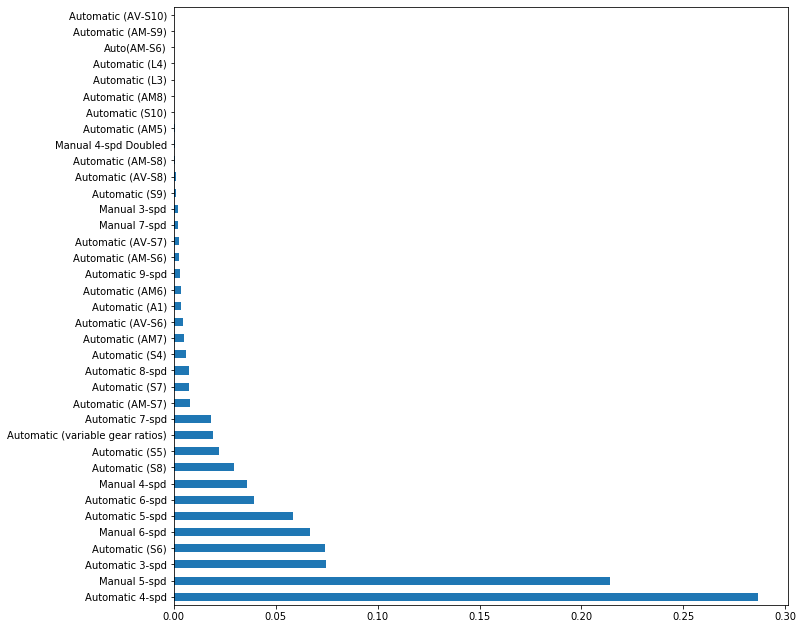

In [16]:
vehiculos.transmision.value_counts(normalize=True).plot.barh();

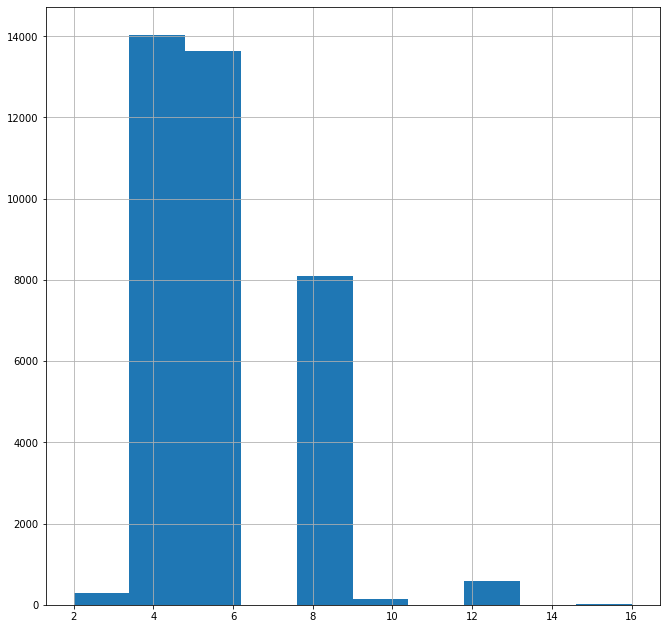

In [17]:
vehiculos.cilindros.hist();

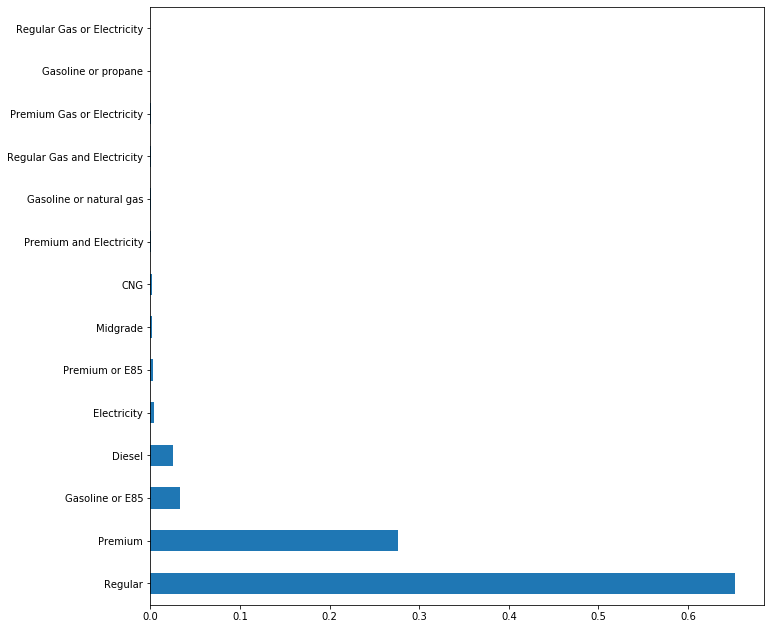

In [20]:
vehiculos.combustible.value_counts(normalize=True).plot.barh();

<b>Valores que no existen</b>

In [23]:
n_records = len(vehiculos)
def valores_inexistentes_col(df) : 
    for columna in df:
        print("{} | {} | {}".format(
            df[columna].name, len(df[df[columna].isnull()])/ (1.0*n_records), df[columna].dtype
        ))
    
valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


<b>valores extremos</b>

Para detectar valores extremos una medida general es considerar outliers aquellos valores con una puntuación Z (z score) mayor de 3, esto es, que se alejan 3 veces o mas desviaciones standard de la media.

El z score se define como:

$$z(x)= \frac{x-\mu}{\sigma}$$

In [28]:
from scipy import stats
import numpy as np

def outliers_col(df):
    for columna in df:
        if df[columna].dtype != np.object:
            n_outliers = len(df[np.abs(stats.zscore(df[columna])) > 3])    
            print("{} | {} | {}".format(
                df[columna].name,
                n_outliers,
                df[columna].dtype
        ))

outliers_col(vehiculos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 233 | int64
co2 | 358 | float64


C:\Users\Le_an\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


los boxplots nos ayudan a preciar de una manera visual la forma que los los outlines se salen

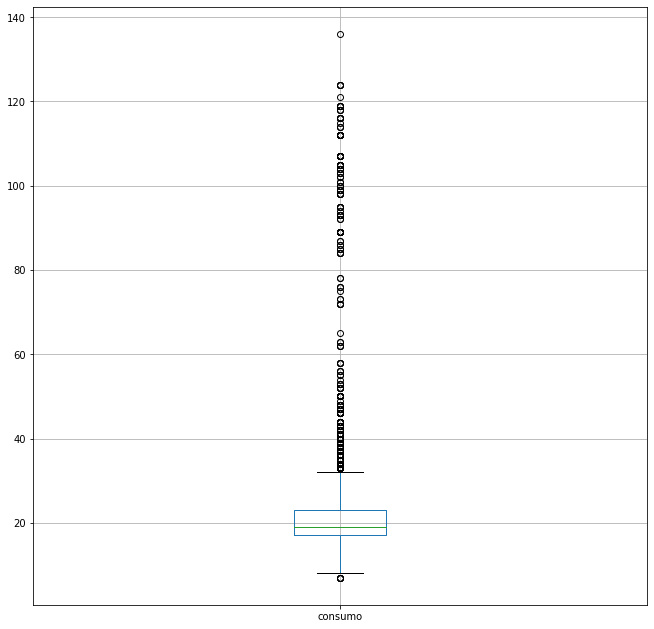

In [29]:
vehiculos.boxplot(column='consumo');


buscamos los vehiculos que no usan gasolina es decir los electricos

In [30]:
vehiculos[vehiculos.co2==0].combustible.unique()

array(['Electricity'], dtype=object)

ahora enlistamos los distintos tipos de combustible

In [31]:
vehiculos.combustible.unique()

array(['Regular', 'Premium', 'Diesel', 'Premium and Electricity',
       'Premium or E85', 'Electricity', 'Premium Gas or Electricity',
       'Gasoline or E85', 'Gasoline or natural gas', 'CNG',
       'Regular Gas or Electricity', 'Midgrade',
       'Regular Gas and Electricity', 'Gasoline or propane'], dtype=object)

vamos a excluir de analisis a los vehiculos hibridos (porque al ser electricos no contaminan)

In [32]:
vehiculos_no_electricos = vehiculos[vehiculos.co2>0]

In [33]:
outliers_col(vehiculos_no_electricos)

year | 0 | int64
desplazamiento | 0 | float64
cilindros | 0 | float64
consumo | 400 | int64
co2 | 221 | float64


C:\Users\Le_an\anaconda3\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


los outliners en consumo practicamente no se reducieron, esto debe ser debido a que los hibridos consumen muy poco conbustible asi que surge la duda, de considerarlos o no para el analisis

In [34]:
vehiculos_no_electricos[
    np.abs(stats.zscore(vehiculos_no_electricos["consumo"])) > 3
].combustible.value_counts(normalize=True)

Regular                        0.7175
Diesel                         0.1525
Premium                        0.0550
Regular Gas and Electricity    0.0475
Premium Gas or Electricity     0.0200
Regular Gas or Electricity     0.0050
Premium and Electricity        0.0025
Name: combustible, dtype: float64

Vemos que no es el caso, que hay outliers en un rango de combustibles tanto híbridos como no híbridos. Asi que son outliers reales.

In [35]:
valores_duplicados_col(vehiculos_no_electricos)

fabricante | 0.099-0.0 | object
modelo | 0.005-0.0 | object
year | 0.038-0.007 | int64
desplazamiento | 0.095-0.0 | float64
cilindros | 0.38-0.0 | float64
transmision | 0.287-0.0 | object
traccion | 0.351-0.005 | object
clase | 0.145-0.0 | object
combustible | 0.652-0.0 | object
consumo | 0.097-0.0 | int64
co2 | 0.084-0.0 | float64


<b>Valores inexistentes</b>

In [36]:
valores_inexistentes_col(vehiculos)

fabricante | 0.0 | object
modelo | 0.0 | object
year | 0.0 | int64
desplazamiento | 0.0037909558624424585 | float64
cilindros | 0.003845112374763065 | float64
transmision | 0.00029786081776333605 | object
traccion | 0.02158137015976171 | object
clase | 0.0 | object
combustible | 0.0 | object
consumo | 0.0 | int64
co2 | 0.0 | float64


In [37]:
Ahora vemos que no hay valores inexistentes extremos en ninguna variable. La variable con mayor numero de valores inexistentes es traccion (2%). Obviamente, los coches electricos no tienen motor de gasolina y por tanto, no tienen cilindros

SyntaxError: invalid syntax (<ipython-input-37-abb59fc81fd2>, line 1)

### Conclusion
- Hay 1506 records duplicados (los hemos removido)
- las variables `desplazamiento, cilindros, transmision y traccion tienen valores inexistentes`
- La variable `combustible` tiene una clase dominante (65% de coches tienen combustible `Regular`)
- hay un outlier en las variables `co2` y `consumo`
- Hay coches hibridos y coches electricos (hemos removido estos ultimos ya que no contaminan).

### Exportamos


In [39]:
vehiculos_no_electricos.to_csv("../../_data/vehiculos.2.limpio_analisis.csv", index=False)